In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_blobs, make_moons, make_circles
from scipy.interpolate import griddata

In [104]:
class ReLU:
    def __repr__(self):
        return "ReLU"
    
    def __str__(self):
        return self.__repr__()

    def forward(self, x : np.ndarray):
        relu = np.where(x>=0, x, 0)
        return relu
    
    def grad(self, y : np.ndarray):
        return np.where(y>=0, 1, 0)

class Linear:
    def __repr__(self):
        return "Linear"
    
    def __str__(self):
        return self.__repr__()

    def forward(self, x : np.ndarray):
        return x
    
    def grad(self, y : np.ndarray):
        return np.ones(shape=y.shape)

class Sigmoid:
    def __repr__(self):
        return "Sigmoid"
    
    def __str__(self):
        return self.__repr__()

    def sigmoid(self, x: np.array):
        return 1 / (1 + np.exp(-x))

    def forward(self, x : np.ndarray):
        return self.sigmoid(x)
    
    def grad(self, y : np.ndarray):
        """Gradient of sigmoid(x) is sigmoid(x)*(1+sigmoid(x)). 
        Proof is in http://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x"""
        s = self.sigmoid(y)
        return s*(1-s)

class MSELoss:
    def forward(self, y_true : np.ndarray, y_pred : np.ndarray):
        return np.mean(np.square(y_true - y_pred)) / 2
    
    def grad(self, y_true : np.ndarray, y_pred : np.ndarray):
        return (y_pred - y_true) / y_true.shape[1]

class BinaryCrossEntropyLoss:
    def forward(self, y_true : np.ndarray, y_pred : np.ndarray):
        y_pred+=1e-3 # to avoid log(0)
        loss = (- y_true*np.log(y_pred) - (1 - y_true) * np.log(np.abs(1 - y_pred))).sum(axis=0).mean()
        return loss
    
    def grad(self, y_true : np.ndarray, y_pred : np.ndarray):
        """This is a general formula. If the output comes from sigmoid then we can use y_pred - y_true"""
        return (y_pred - y_true)/(y_pred * (1 - y_pred))
    
class FullyConnectedLayer:
    def __init__(self, n_i : int, n_o : int, activation):
        self.w = np.random.randn(n_o, n_i) * (2/n_i)
        # print('std', 1/np.sqrt(n_i))
        self.b = np.random.randn(n_o, 1) * (2/n_i)
        self.activation = activation
    
    def __repr__(self):
        return f"FullyConnectedLayer({self.w.shape=}, {self.activation=})"
    
    def __str__(self):
        return self.__repr__()

    def forward(self, x : np.ndarray):
        z = np.matmul(self.w, x) + self.b

        y = self.activation.forward(z)

        return y, z
    
    def backward(self, y_prev : np.ndarray, z : np.ndarray, prev_grad_z : np.ndarray, next_w : np.ndarray = None, lr=0.001):
        if next_w is not None: # next layer has weight means, this is not the last layer
            curr_grad_z = np.matmul(next_w.T, prev_grad_z) * self.activation.grad(z)
        else: # this is the last layer
            curr_grad_z = prev_grad_z * self.activation.grad(z)
        
        m = y_prev.shape[1]

        dw = 1/m * np.matmul(curr_grad_z, y_prev.T)
        db = 1/m * np.sum(curr_grad_z, axis=1, keepdims=True)

        self.w = self.w - lr * dw
        self.b = self.b - lr * db
        
        return curr_grad_z

class SequentialModel:
    def __init__(self, layers : list[FullyConnectedLayer], loss : MSELoss):
        self.layers = layers
        self.loss = loss
    
    def summary(self):
        print("""SequentialModel\n\t|""")
        print('\n'.join(['\t|--->'+str(l) for l in self.layers]))

    def forward(self, x : np.ndarray):
        cache = []
        y = x
        for layer in self.layers:
            y, z = layer.forward(y)
            cache.append({'y':y, 'z':z})
        return y, cache
    
    def backward(self, x : np.ndarray, y_true : np.ndarray, y_pred : np.ndarray, cache : list[dict[str, np.ndarray]], lr : float):
        loss_grad = self.loss.grad(y_true=y_true, y_pred=y_pred)

        for i in range(len(self.layers)-1, -1, -1):
            if i == 0:
                dz = self.layers[i].backward(y_prev = x, z = cache[i]['z'], prev_grad_z= dz, next_w=self.layers[i+1].w, lr=lr) # input layer
            elif i == len(self.layers)-1:
                dz = self.layers[i].backward(y_prev = cache[i-1]['y'], z = cache[i]['z'], prev_grad_z=loss_grad, next_w= None, lr=lr) # last layer doesn't have next layer
            else:
                dz = self.layers[i].backward(y_prev=cache[i-1]['y'], z= cache[i]['z'], prev_grad_z=dz, next_w=self.layers[i+1].w, lr=lr)

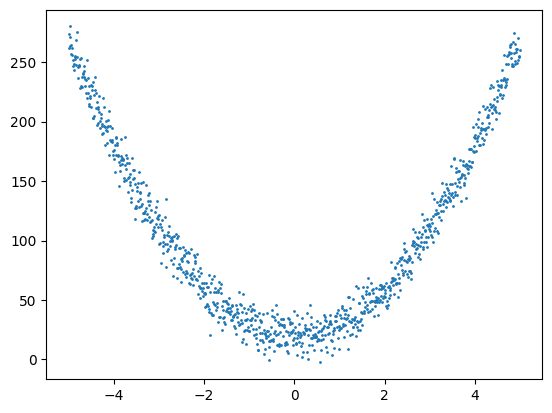

SequentialModel
	|
	|--->FullyConnectedLayer(self.w.shape=(10, 1), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(1, 10), self.activation=Linear)
Epoch: 1000, Loss: 117.5903074310517
Epoch: 2000, Loss: 64.5840274247247
Epoch: 3000, Loss: 55.48028458259817
Epoch: 4000, Loss: 53.073257098982445
Epoch: 5000, Loss: 51.891229839019594
Epoch: 6000, Loss: 51.19613329231113
Epoch: 7000, Loss: 50.76773315798574
Epoch: 8000, Loss: 50.23780139396219
Epoch: 9000, Loss: 49.75234744579119
Epoch: 10000, Loss: 49.426379558625385


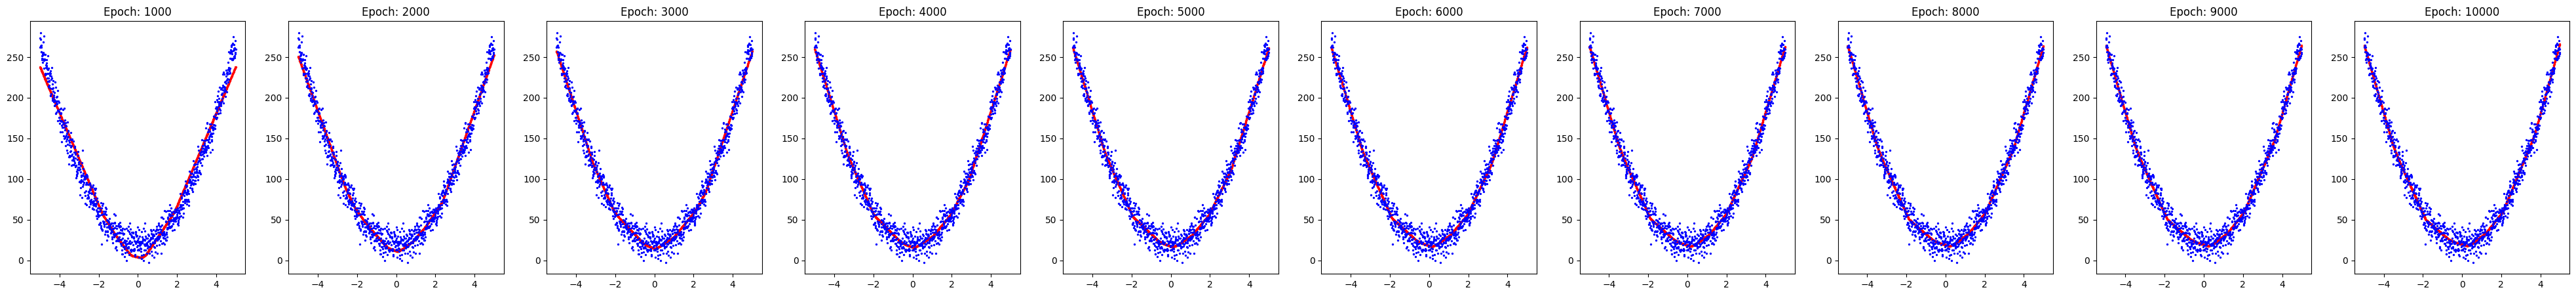

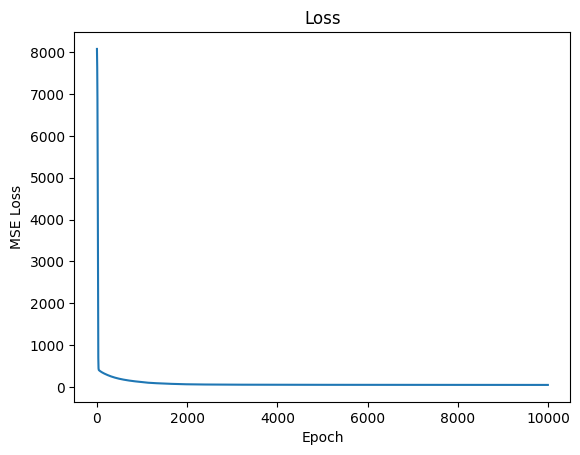

In [24]:
# Random Data Creation
x = np.arange(-5, 5 , 0.01).reshape(1,-1)
y = 10*(x**2)+20 + np.random.normal(size=x.shape)*10
x.shape, y.shape

# Data Plot
plt.scatter(x.flatten(), y.flatten(), s = 1)
plt.show()

# Layers Definition
n = 10
layers = [
    FullyConnectedLayer(1, n, activation=ReLU()),
    *[FullyConnectedLayer(n, n, activation=ReLU()) for i in range(1)],
    FullyConnectedLayer(n, 1, activation=Linear()),
]

model = SequentialModel(layers=layers, loss=MSELoss())
model.summary()

# Training Loop
epochs = []
losses = []
e = 10000
step = 1000
fig, axs = plt.subplots(ncols=e//step, figsize=(5*e//step,5))
for epoch in range(e):
    y_pred, cache = model.forward(x)
    loss = model.loss.forward(y, y_pred)
    epochs.append(epoch)
    losses.append(loss)
    model.backward(x, y, y_pred, cache, 0.1)
    if (epoch+1)%step==0:
        print(f"Epoch: {epoch+1}, Loss: {loss}")
        axs[(epoch+1)//step-1].scatter(x.flatten(), y_pred.flatten(), s=2, c='r')
        axs[(epoch+1)//step-1].scatter(x.flatten(), y.flatten(), s=2, c='b')
        axs[(epoch+1)//step-1].set_title(f"Epoch: {epoch+1}")
plt.show()

plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss')
plt.show()

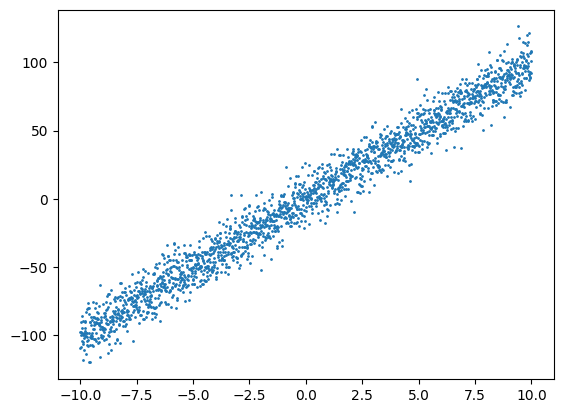

SequentialModel
	|
	|--->FullyConnectedLayer(self.w.shape=(10, 1), self.activation=Linear)
	|--->FullyConnectedLayer(self.w.shape=(1, 10), self.activation=Linear)
Epoch: 1000, Loss: 504.76818614774504
Epoch: 2000, Loss: 153.85544589374013
Epoch: 3000, Loss: 76.15183399018275
Epoch: 4000, Loss: 59.52075713369523
Epoch: 5000, Loss: 55.86320724909438


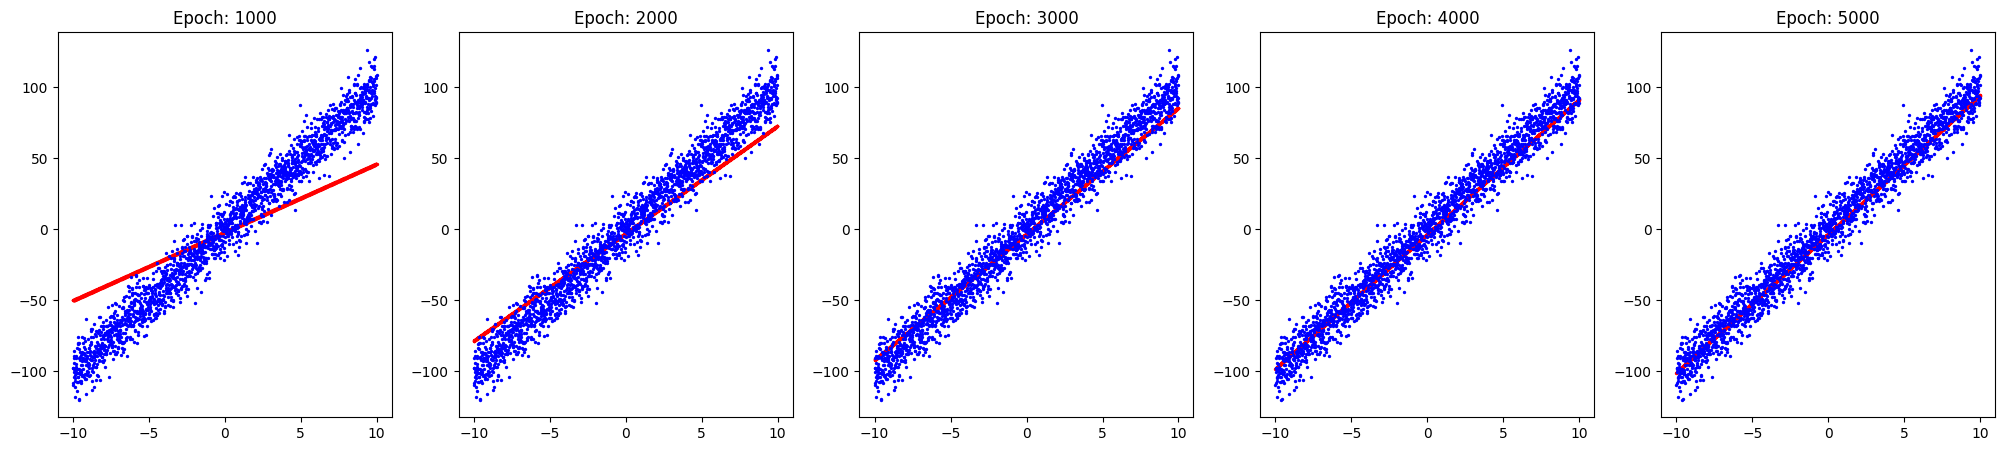

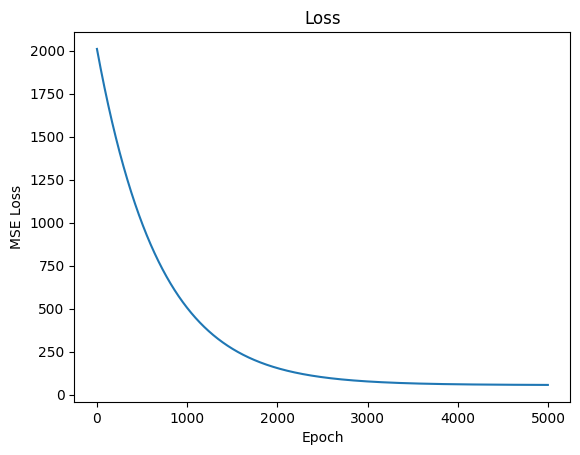

In [25]:
# Random Data Creation
x = np.arange(-10, 10 , 0.01).reshape(1,-1)
y = 10*x + np.random.normal(size=x.shape)*10
x.shape, y.shape

# Data Plot
plt.scatter(x.flatten(), y.flatten(), s = 1)
plt.show()

# Layers Definition
layers2 = [
    FullyConnectedLayer(1, n, activation=Linear()),
    FullyConnectedLayer(n, 1, activation=Linear()),
]

model2 = SequentialModel(layers=layers2, loss=MSELoss())
model2.summary()

# Training Loop
epochs = []
losses = []
e = 5000
step = 1000
fig, axs = plt.subplots(ncols=e//step, figsize=(5*e//step,5))
for epoch in range(e):
    y_pred, cache = model2.forward(x)
    loss = model2.loss.forward(y, y_pred)
    epochs.append(epoch)
    losses.append(loss)
    model2.backward(x, y, y_pred, cache, 0.001)
    if (epoch+1)%step==0:
        print(f"Epoch: {epoch+1}, Loss: {loss}")
        axs[(epoch+1)//step-1].scatter(x.flatten(), y_pred.flatten(), s=2, c='r')
        axs[(epoch+1)//step-1].scatter(x.flatten(), y.flatten(), s=2, c='b')
        axs[(epoch+1)//step-1].set_title(f"Epoch: {epoch+1}")
plt.show()

plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss')
plt.show()

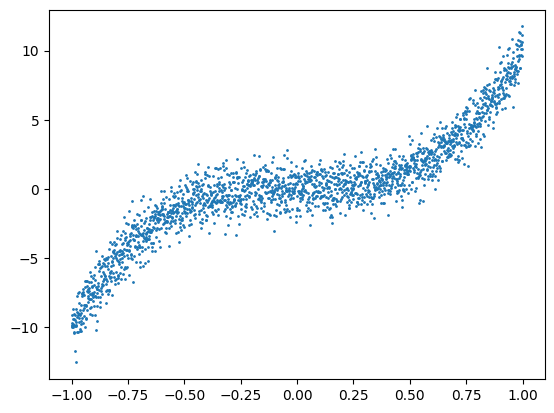

SequentialModel
	|
	|--->FullyConnectedLayer(self.w.shape=(10, 1), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=Linear)
	|--->FullyConnectedLayer(self.w.shape=(1, 10), self.activation=Linear)
Epoch: 5000, Loss: 1.2794902268454234
Epoch: 10000, Loss: 0.5672662461999669
Epoch: 15000, Loss: 0.5151828768228105
Epoch: 20000, Loss: 0.5122970660412041
Epoch: 25000, Loss: 0.5102037473328587


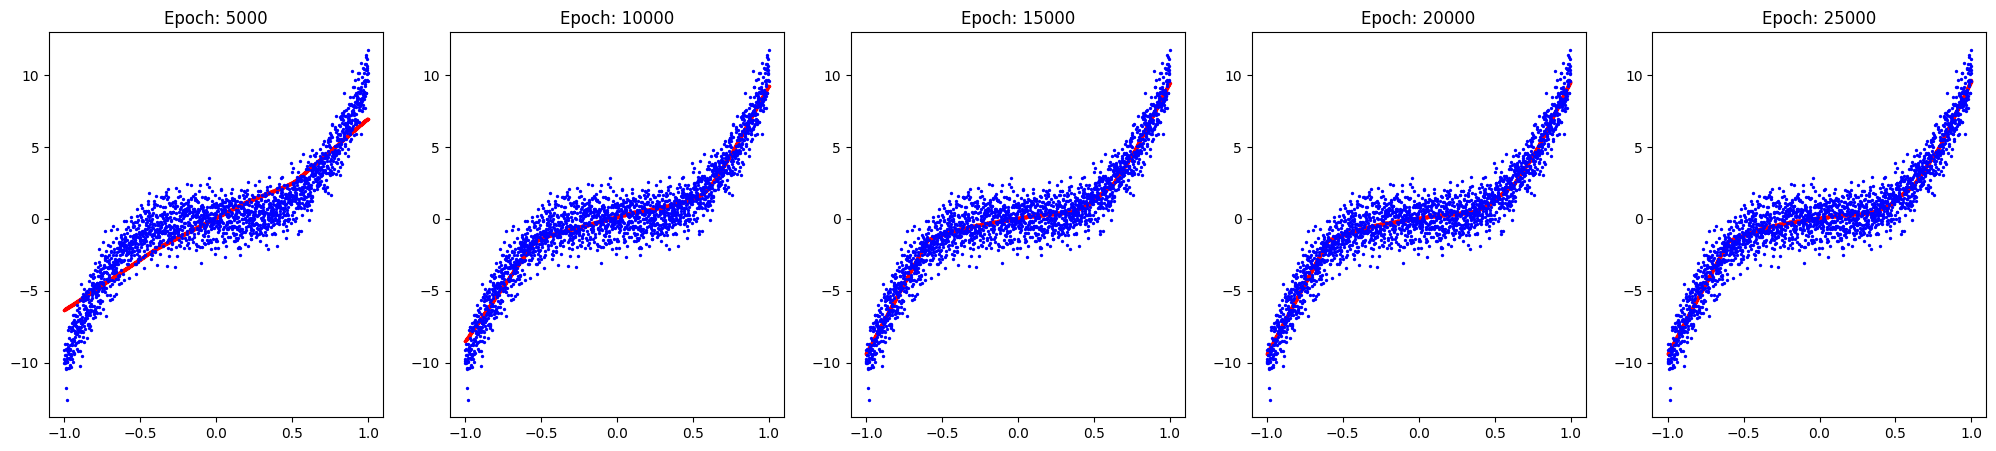

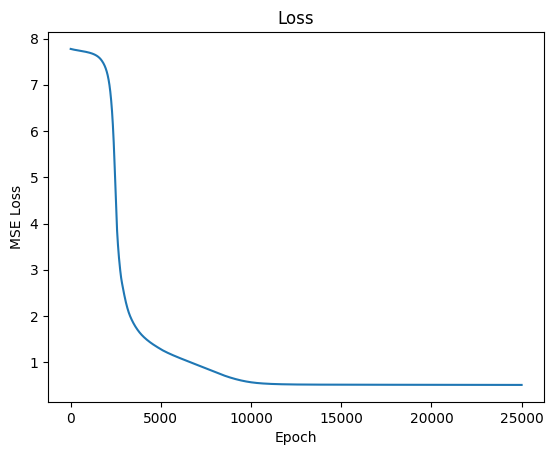

In [26]:
# Random Data Creation
x = np.arange(-10, 10 , 0.01).reshape(1,-1)/10
y = 10 * x**3 + np.random.normal(size=x.shape)
x.shape, y.shape

# Data Plot
plt.scatter(x.flatten(), y.flatten(), s = 1)
plt.show()

# Layers Definition
n = 10
layers3 = [
    FullyConnectedLayer(1, n, activation=ReLU()),
    *[FullyConnectedLayer(n, n, activation=ReLU()) for i in range(5)],
    FullyConnectedLayer(n, n, activation=Linear()),
    FullyConnectedLayer(n, 1, activation=Linear())
]

model3 = SequentialModel(layers=layers3, loss=MSELoss())
model3.summary()

# Training Loop
epochs = []
losses = []
e = 25000
step = 5000
fig, axs = plt.subplots(ncols=e//step, figsize=(5*e//step,5))
for epoch in range(e):
    y_pred, cache = model3.forward(x)
    loss = model3.loss.forward(y, y_pred)
    epochs.append(epoch)
    losses.append(loss)
    model3.backward(x, y, y_pred, cache, 1)
    if (epoch+1)%step==0:
        print(f"Epoch: {epoch+1}, Loss: {loss}")
        axs[(epoch+1)//step-1].scatter(x.flatten(), y_pred.flatten(), s=2, c='r')
        axs[(epoch+1)//step-1].scatter(x.flatten(), y.flatten(), s=2, c='b')
        axs[(epoch+1)//step-1].set_title(f"Epoch: {epoch+1}")
plt.show()

plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss')
plt.show()

In [13]:
def plot_contour(x,y,z,resolution = 50,contour_method='linear'):
    resolution = str(resolution)+'j'
    X,Y = np.mgrid[min(x):max(x):complex(resolution),   min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method=contour_method)
    return X,Y,Z

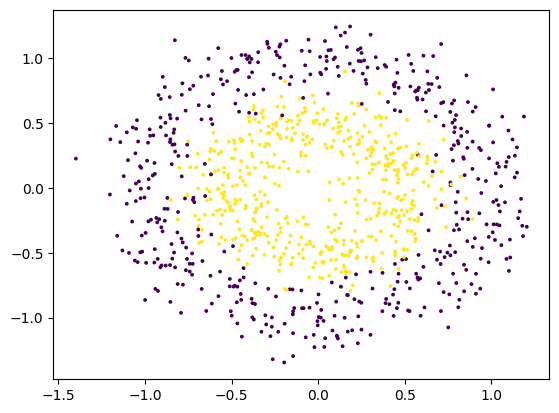

SequentialModel
	|
	|--->FullyConnectedLayer(self.w.shape=(10, 2), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(10, 10), self.activation=ReLU)
	|--->FullyConnectedLayer(self.w.shape=(1, 10), self.activation=Sigmoid)
Epoch: 2000, Loss: 0.6920449728378985
Epoch: 4000, Loss: 0.6708997259622188
Epoch: 6000, Loss: 0.13044751057338572
Epoch: 8000, Loss: 0.12690110696945184
Epoch: 10000, Loss: 0.1258411468216927


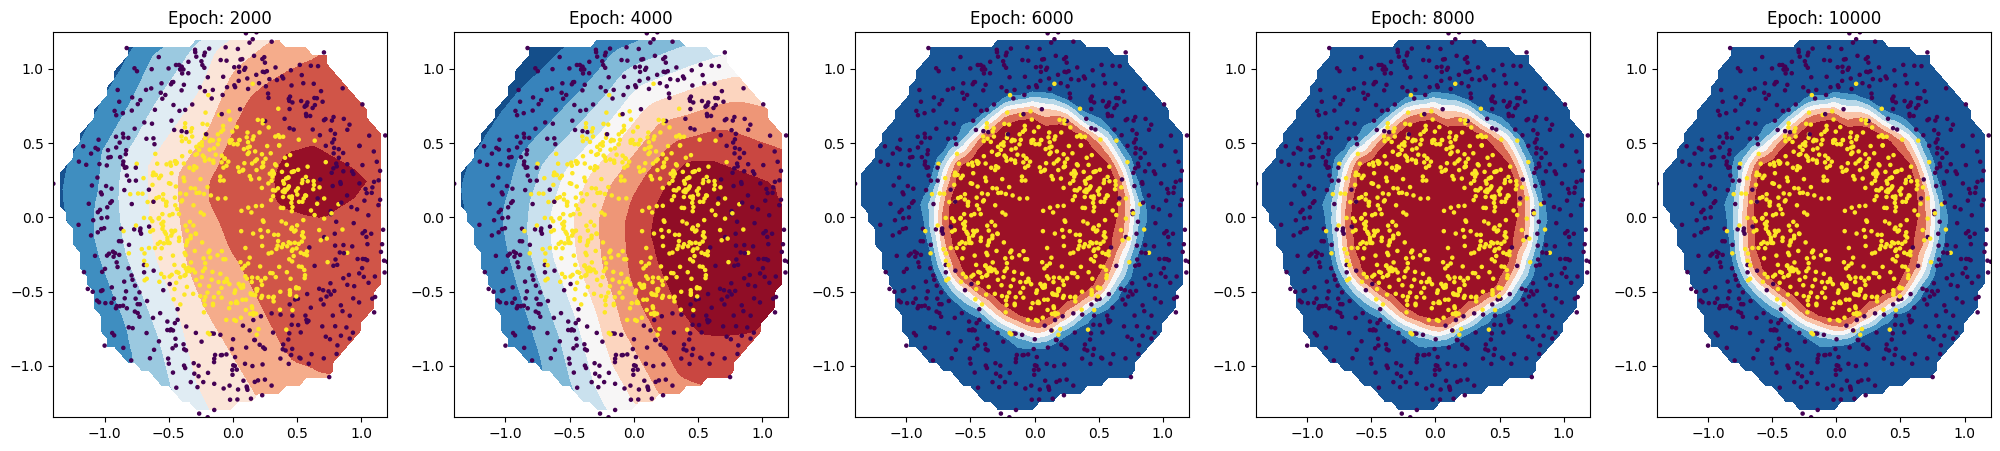

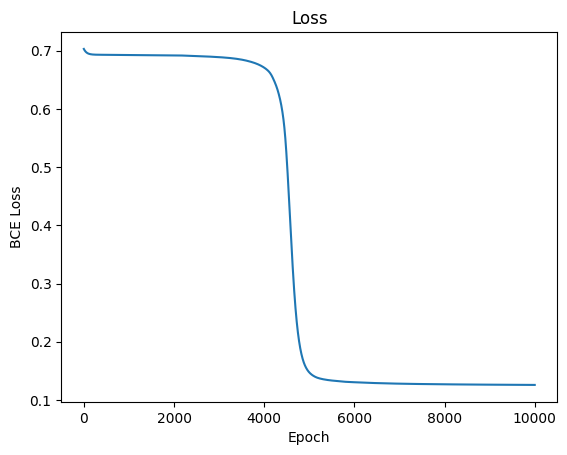

In [105]:
# Data Creation
# x, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_classes=2)
x, y = make_circles(n_samples=1000, random_state=42, noise=0.15, factor=0.5)
x = x.T # Reshaping to (f,B)
y = y.reshape(1,-1) # Reshaping to (c,B)

# Vizualizing data
plt.scatter(x[0,:], x[1,:], c=y.flatten(), s = 3)
plt.show()

# Layers Definition
n = 10
layers3 = [
    FullyConnectedLayer(2, n, activation=ReLU()),
    *[FullyConnectedLayer(n, n, activation=ReLU()) for i in range(5)],
    FullyConnectedLayer(n, n, activation=ReLU()),
    FullyConnectedLayer(n, 1, activation=Sigmoid())
]

model3 = SequentialModel(layers=layers3, loss=BinaryCrossEntropyLoss())
model3.summary()

# Training Loop
epochs = []
losses = []
e = 10000
step = 2000
fig, axs = plt.subplots(ncols=e//step, figsize=(5*e//step,5))
for epoch in range(e):
    y_pred, cache = model3.forward(x)
    loss = model3.loss.forward(y, y_pred)
    epochs.append(epoch)
    losses.append(loss)
    model3.backward(x, y, y_pred, cache, 0.013)
    if (epoch+1)%step==0:
        print(f"Epoch: {epoch+1}, Loss: {loss}")
        X,Y,Z = plot_contour(x[0,:], x[1,:],y_pred.flatten())
        axs[(epoch+1)//step-1].contourf(X,Y,Z, cmap="RdBu_r")
        axs[(epoch+1)//step-1].scatter(x[0,:], x[1,:], s=5, c=y.flatten())
        axs[(epoch+1)//step-1].set_title(f"Epoch: {epoch+1}")
plt.show()

plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('Loss')
plt.show()